Let's try to use a coregionalized kernel model

In [2]:
!pip install GPy

     |████████████████████████████████| 1.5 MB 935 kB/s eta 0:00:01
     |████████████████████████████████| 71 kB 1.7 MB/s eta 0:00:01
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102549 sha256=a3b8541dcf82f643b1f711c161a4d3262027967538a743ec3da1e6cb91255c1a
  Stored in directory: /Users/kevinmaikjablonka/Library/Caches/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built paramz


In [227]:
import GPy
import numpy as np 
import pandas as pd
import joblib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

import sys
sys.path.append('../')
from colorml.utils import mapping_to_target_range, get_timestamp_string, plot_predictions, huber_fn, mapping_to_target_range_sig, read_pickle, augment_data
from colorml.descriptornames import * 

In [309]:
df_train = pd.read_csv('../data/development_set.csv')
df_test = pd.read_csv('../data/holdout_set.csv')

In [310]:
train_names = df_train['color_cleaned']

In [311]:
test_names = df_test['color_cleaned']

In [312]:
sfs = joblib.load('../work/sfs.joblib')

In [313]:
CHEMICAL_FEATURES = (
        metalcenter_descriptors
        + functionalgroup_descriptors
        + linker_descriptors
        + mol_desc
        + summed_functionalgroup_descriptors
        + summed_linker_descriptors
        + summed_metalcenter_descriptors
    )

In [314]:
NFEAT = 15

In [315]:
X_train = df_train[CHEMICAL_FEATURES].values
X_test = df_test[CHEMICAL_FEATURES].values

scaler = StandardScaler()

vt = VarianceThreshold(0.6)
X_train = vt.fit_transform(X_train)
X_test = vt.transform(X_test)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# X_train = sfs.transform(X_train)
# X_test = sfs.transform(X_test)

pca = PCA(NFEAT)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
y_train = df_train[['r', 'g', 'b']].values / 255 - 0.5 
y_test = df_test[['r', 'g', 'b']].values / 255 - 0.5

In [316]:
X_train.shape

(4480, 15)

In [317]:
y_train[:,0].flatten().shape

(4480,)

In [318]:
K = GPy.kern.RBF(NFEAT) + GPy.kern.Bias(NFEAT)
icm = GPy.util.multioutput.ICM(input_dim=NFEAT,num_outputs=3,kernel=K)
m = GPy.models.GPCoregionalizedRegression([X_train, X_train, X_train], 
                                                [y_train[:,0].reshape(-1,1), y_train[:,1].reshape(-1,1), y_train[:,2].reshape(-1,1)], 
                                                kernel=icm)

In [319]:
m

gp.,value,constraints,priors
ICM.sum.rbf.variance,1.0,+ve,
ICM.sum.rbf.lengthscale,1.0,+ve,
ICM.sum.bias.variance,1.0,+ve,
ICM.B.W,"(3, 1)",,
ICM.B.kappa,"(3,)",+ve,
mixed_noise.Gaussian_noise_0.variance,1.0,+ve,
mixed_noise.Gaussian_noise_1.variance,1.0,+ve,
mixed_noise.Gaussian_noise_2.variance,1.0,+ve,


In [ ]:
m.optimize(messages=True)

In [297]:
m

gp.,value,constraints,priors
ICM.sum.rbf.variance,0.026455820291315383,+ve,
ICM.sum.rbf.lengthscale,1.1770132716157111,+ve,
ICM.sum.bias.variance,0.010285727674393742,+ve,
ICM.B.W,"(3, 1)",,
ICM.B.kappa,"(3,)",+ve,
mixed_noise.Gaussian_noise_0.variance,0.04494143470177549,+ve,
mixed_noise.Gaussian_noise_1.variance,0.04526542789959393,+ve,
mixed_noise.Gaussian_noise_2.variance,0.08289395947222762,+ve,


In [261]:
joblib.dump(m, 'coreg_3.joblib')

['coreg_3.joblib']

In [303]:
newX = np.hstack([X_test,np.ones_like(X_test)*2])
mu2, var =m.predict(newX,Y_metadata={'output_index':2*np.ones((newX.shape[0],1)).astype(int)})

In [304]:
newX = np.hstack([X_test,np.ones_like(X_test)])
mu1, var =m.predict(newX,Y_metadata={'output_index':np.ones((newX.shape[0],1)).astype(int)})

In [305]:
newX = np.hstack([X_test,0*np.ones_like(X_test)])
mu0, var =m.predict(newX,Y_metadata={'output_index':0*np.ones((newX.shape[0],1)).astype(int)})

In [306]:
predictions = np.hstack([mu0, mu1, mu2])

 ../colorml/utils.py:159: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


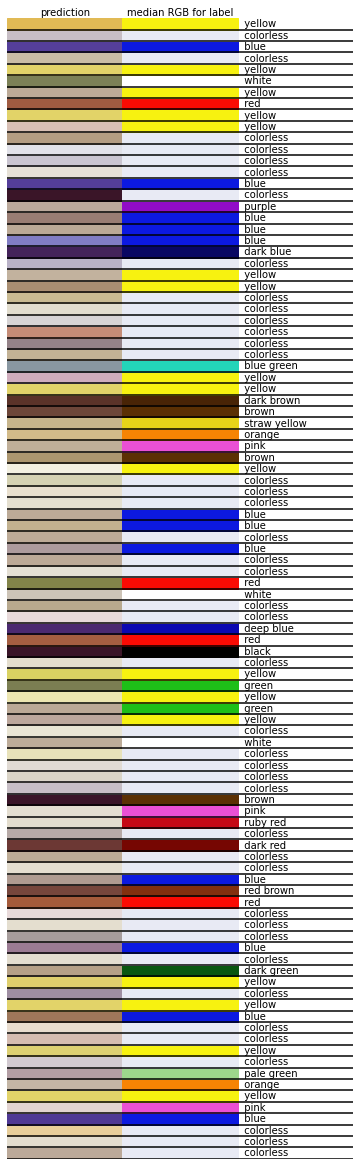

In [307]:
plot_predictions((predictions + 0.5) * 255, (y_test+0.5) * 255,  test_names.values,  sample=100)